<a href="https://colab.research.google.com/github/VictorVazquezRey/03MAIR--Algoritmos-de-Optimizacion--2020/blob/master/Victor_Vazquez_AG2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Actividad guiada 2 de Algoritmos de Optimización**
*Victor Vazquez Rey*

[https://colab.research.google.com/drive/19H0P42j7zkESSPayYqQ4xfT7uA5pePOP?usp=sharing](https://colab.research.google.com/drive/19H0P42j7zkESSPayYqQ4xfT7uA5pePOP?usp=sharing)

[https://github.com/VictorVazquezRey/03MAIR--Algoritmos-de-Optimizacion--2020](https://github.com/VictorVazquezRey/03MAIR--Algoritmos-de-Optimizacion--2020)

In [2]:
%alias_magic t time

Created `%t` as an alias for `%time`.
Created `%%t` as an alias for `%%time`.


#### **Resolución del problema del viaje por el río con la técnica de programación dinámica**

In [ ]:
import numpy as np
from math import inf 

def cruiser(T:'nparray', origin_pier: int, target_pier: int) -> list:
    C = [[0,[target_pier]]]
    for i in range(target_pier - 1, origin_pier - 1, -1):
        pier = i
        cost = T[pier][target_pier]
        for j in range (i+1, target_pier):
            actual_cost = T[i][j] + C[i-j][0]
            if actual_cost < cost:
                cost = actual_cost
                pier = j

        to_insert = [cost,[i] + C[i-pier][1]]
        C.append(to_insert)
        # print(C)
    return C.pop()
    



T = np.array(
            [
                [0  , 5  , 4  , 3  , inf, inf, inf],
                [inf, 0  , inf, 2  , 3  , inf, 11],
                [inf, inf, 0  , 1  , inf, 4  , 10],
                [inf, inf, inf, 0  , 5  , 6  , 9],
                [inf, inf, inf, inf, 0  , inf, 4 ],
                [inf, inf, inf, inf, inf, 0  , 3],
                [inf, inf, inf, inf, inf, inf, 0, ]
            ])

print(cruiser(T, 0, 6))

[11.0, [0, 2, 5, 6]]


##### **Estudio de la complejidad computacional**

Si tomamos como tamaño del problema al número de embarcaderos y lo designamos por $n$.

Podemos observar que la instrucción crítica es la comparación implícita del bucle más interno y por tanto podemos calcular la complejidad viendo cuántas veces se ejecuta (la llamada a append se considera $\in O(1)$) y esta se ejecuta(aunque el bucle más externo vaya del revés el conteo es el mismo):

$\require{cancel}$
\begin{align}
\sum_{i=1}^{n} \sum_{j=i+1}^{n} 1 &= \sum_{i=1}^{n} n - i \cancel{- 1} \cancel{+ 1} && \text{Resolviendo el sumatorio interno} \\
&= (n-1) + (n-2) + \cdots + 1 + 0 && \text{Desarrollando el sumatorio} \\
&= \sum_{i=1}^{n} i && \text{La suma de una sucesión aritmética} \\
&= \frac{(1+n)}{2} \cdot n \\
&= \frac{(n^2+n)}{2} \in O(n^2)
\end{align}



#### **Resolución del problema de asignación de tareas**

##### **Primera aproximación: Fuerza bruta**
El problema establece una restricción, y es que la dimensionalidad  es cuadrada. Así que el número de tareas y de agentes es igual y cada tarea debe ser asignado a un único agente y para cada agente hay una única tarea.

Siendo así se modela con una tupla n-dimensional siendo $n$ el número de agentes (o de tareas) y donde la posición en la tupla indica el agente al que se le asigna la tarea y el valor en esa posición es por tanto la tarea que se le asigna a ese agente.

E.g.:
Sea (1, 0, 2, 3) una asignación, entonces, la tarea 1 ha sido asignada al agente 0, la tarea 0 al agente 1 y así sucesivamente.

En esa implementación se usa la funcion itertools.permutations que genera todas tuplas para una dimensión.

In [3]:
%t
import numpy as np
import itertools as it
from math import inf

def cost(cost_matrix:'nparray', assignament: tuple)->float:
    cost = 0
    for job, agent in enumerate(assignament):
        cost += costs_matrix[agent][job]
    return cost

def assignaments_brute_force(cost_matrix:'nparray')->tuple:
    dimension = costs_matrix.shape[0]
    min_cost = inf
    result = ()
    for assignament in list(it.permutations(range(dimension))):
        actual_cost = cost(costs_matrix, assignament)
        if actual_cost < min_cost:
            min_cost = actual_cost
            result = assignament

    return result, min_cost


dimension = 10
#generación automática y aleatoria de la matriz de costes.
costs_matrix = np.random.randint(1, 26, size=(dimension, dimension))
# print(costs_matrix)
assignament, assignament_cost = assignaments_brute_force(costs_matrix)
print('La mejor asignación de tareas es:', assignament,'con un coste total de:',
      assignament_cost)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.29 µs
La mejor asignación de tareas es: (4, 3, 9, 8, 0, 5, 1, 6, 2, 7) con un coste total de: 39


##### **Estudio de la complejidad computacional**

Si tomamos como tamaño del problema a la dimension antes descrita y la llamamos $n$.

La instrucción crítica de este algoritmo es la comparación del bucle for que se ejecuta una vez más del las iteraciones dentro del bucle.

El número de iteraciones dependerá del número de elementos de la lista generada por it.permutations y puesto que genera tantas tuplas como permutaciones de elementos desde 0..dimension-1, el número de iteraciones es $n!$ y la instrucción crítica se ejecuta $n!+1$ veces que $\in O(n!)$

Cambiando sucesivamente el valor de la variable dimensión, observamos que el algoritmo por fuerza bruta deja de ser una opción por encima de una **dimension 10**

##### **Aproximación con ramificación y poda**

Para la resolución de este ejercicio haré uso de dos clases para encapsular la información.

Una clase Node que se usa para guardar la asignación de tareas hasta ese momento con un coste asociado estimado superior e inferiormente que se utiliza en el criterio de poda. En esta clase se sobreescriben funciones tales como la de igualdad y menor que (para que permita ordenar), y la representación para poder imprimirlas.

Una clase Task_Asignament que implementa el algoritmo. 

In [6]:
import numpy as np
from math import inf


class Node:
    info = ()
    lb = 0
    ub = 0

    def __init__(self, info: tuple = (), lb: int = 0, up: int = 0):
        self.info = info
        self.lb = lb
        self.ub = up

    def __repr__(self):
        return "Node(info:{},lb:{},ub:{})".format(self.info, self.lb, self.ub)

    def __str__(self):
        return "[info:{},lb:{},ub:{}]".format(self.info, self.lb, self.ub)

    def __eq__(self, other):
        if isinstance(other, Node):
            return self.info == other.info and self.lb == other.lb and self.ub == other.ub
        return False

    def __lt__(self, other):
        if isinstance(other, Node):
            return self.lb < other.lb
        return False

In [7]:
class Task_Assignament:
    dimension = None
    costs_matrix = None
    nodes = []
    upper = inf

    def __init__(self, dimension, costs_matrix=None, less_cost=1, high_cost=25):
        self.dimension = dimension
        self.upper = inf
        if costs_matrix is None:
            self.costs_matrix = np.random.randint(less_cost,
                                                  high_cost + 1,
                                                  size=(dimension, dimension))
        else:
            self.costs_matrix = costs_matrix

    # O(len(assignament))
    def cost(self, assignament: tuple) -> float:
        cost = 0
        for agent, job in enumerate(assignament):
            cost += self.costs_matrix[agent][job]
        return cost

    #O((n-len(assignament))^2)
    def lower_and_upper_bound_cost(self, assignament: tuple) -> tuple:
        fixed_cost = self.cost(assignament)

        unassigned_tasks = set(range(self.dimension)) - set(assignament)
        unassigned_agents = range(len(assignament), self.dimension)

        estimated_min_cost = 0
        estimated_max_cost = 0
        for agent in unassigned_agents:
            costs_for_agent_rest_of_tasks = [self.costs_matrix[agent][task] for task in unassigned_tasks]
            estimated_min_cost += min(costs_for_agent_rest_of_tasks)
            estimated_max_cost += max(costs_for_agent_rest_of_tasks)

        return fixed_cost + estimated_max_cost, fixed_cost + estimated_min_cost

    def branch(self, parent: Node) -> list:
        to_expand = set(range(self.dimension)) - set(parent.info)
        children = []
        for task in to_expand:
            info = parent.info + (task,)
            max, min = self.lower_and_upper_bound_cost(info)
            # Si cumple la condición de poda no se expande.
            if min < self.upper:
                if max < self.upper:
                    self.upper = max
                node = Node(info, min, max)
                children.append(node)
            # Esta condición es de solución y por tanto la poda puede ser más dramática.
            elif min==max and min == self.upper:
                self.nodes = []
                return [Node(info, min, max)]

        return sorted(children)

    def assignaments(self) -> list:
        self.nodes = self.branch(Node())
        solution = None
        while self.nodes and not solution:
            # print('expandidos:', self.nodes)
            candidate = self.nodes.pop(0)
            # print('candidato:', candidate, 'lsup:', self.upper)
            if len(candidate.info) < self.dimension:
                b = self.branch(candidate)
                self.nodes = self.nodes + b
                self.nodes.sort()
            else:
                return [candidate.info, candidate.ub]
        return None


Este es el uso de la clase anterior. Basta con generar la matriz de costes, crear una instancia de la clase Task_Assignament y llamar al método assignaments.


In [15]:
%%t
dimension = 15

# generación automática y aleatoria de la matriz de costes.
costs_matrix = np.random.randint(1, 26, size=(dimension, dimension))
ta = Task_Assignament(dimension, costs_matrix)
print(ta.assignaments())

[(11, 12, 2, 8, 1, 13, 5, 4, 10, 0, 7, 6, 9, 14, 3), 38]
CPU times: user 410 ms, sys: 1 ms, total: 411 ms
Wall time: 410 ms


##### **Estudio de la complejidad computacional**

Si tomamos como tamaño del problema a la dimension antes descrita y la llamamos $n$.

El estudio de la complejidad en este algoritmo no es sencilla. La poda es una cuestión probabilistica, aunque se encuentra que tiene un coste en el peor caso que es exponencial.

Encontramos que de media una dimensión por encima de 15 deja de ser una opción.

#### **Descenso del gradiente con un paraboloide**

Los dos problemas que se van a resolver con la técnica del descenso del gradiente van a hacer uso de la clase siguiente que permite encapsular el código
que se va a reutilizar.

Esta clase no sólo calcula las sucesivas aproximaciones del mínimo sino que además ofrece dos utilidades para dibujar la función en 3d y crear una animación con la aproximación de la solución al mínimo en un mapa de contornos.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from random import uniform
from matplotlib import animation,rc
from IPython.display import HTML

class GradientDescent:

    def __init__(self,f:'function', gradient:'function'=None,
                 limx: int=10, limy:int=10, delta:float=.001,
                 learning_rate:float=.3,steps:int=100, criteria:float=1e-3,
                 number_of_points:int=100, theme:str="Blues"):
        self.f = f
        if gradient is not None:
            self.gradient = gradient
        else:
            self.gradient = self.grad        
        self.learning_rate = learning_rate
        self.limx = limx
        self.limy = limy
        self.delta = delta
        self.steps = steps
        self.criteria = criteria
        self.x_aprox_min, self.y_aprox_min = self.generate_points()
        self.number_of_point = number_of_points
        self.theme = theme

        # data for plotting
        x = np.linspace(-self.limx, self.limx, number_of_points)
        y = x
        self.X, self.Y = np.meshgrid(x, y)
        self.Z = self.f(self.X, self.Y)

    def grad(self,x:float, y:float):
        df_dx = (self.f(x+self.delta, y)-self.f(x,y))/self.delta
        df_dy = (self.f(x, y+self.delta)-self.f(x,y))/self.delta
        return [df_dx, df_dy]

    def generate_points(self):
        x = [uniform(self.limx/2, -self.limx/2)]
        y = [uniform(self.limy/2, -self.limy/2)]

        for _ in range(self.steps):
            grad = self.gradient(x[-1], y[-1])
            update_x = self.learning_rate * grad[0]
            update_y = self.learning_rate * grad[1]
            if max(abs(update_x), abs(update_y)) < self.criteria:
                break
            x.append(x[-1] - update_x)
            y.append(y[-1] - update_y)

        return x,y

    def plot(self):
        # function plot
        fig = plt.figure()
        ax = plt.axes(projection="3d")

        surf = ax.plot_surface(self.X, self.Y, self.Z, cmap=self.theme)

        cset = ax.contourf(self.X, self.Y, self.Z, zdir='z',
                           offset=np.min(self.Z), cmap=self.theme)

        # colorbar
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, alpha=0.8)

        plt.axis('off')
        plt.show()

    def update(self,i: float):
        self.ax.plot(self.x_aprox_min[:i], self.y_aprox_min[:i], color="green",
                     linewidth=3.0, alpha=0.8)
        # Doesn't work on colab.
        # self.plt.title('Punto: {:f}, {:f}'.format(self.x_aprox_min[i],
        #                                           self.y_aprox_min[i]))

    def animation(self):
        self.fig, self.ax = plt.subplots()
        self.plt = plt
        plt.close()

        cset = self.ax.contourf(self.X, self.Y, self.Z, cmap=self.theme)
        # colorbar
        self.fig.colorbar(cset, ax=self.ax, shrink=0.5, aspect=5, alpha=0.8)

        self.anim = animation.FuncAnimation(self.fig, self.update,
                                            range(len(self.x_aprox_min)),
                                            repeat=False)

Para usar la clase anterior hay que definir la función a minimizar y la función gradiente.
Existen diversos parámetros para configurar como la tasa de crecimiento, el número de puntos para mostrar en la gráfica, ect,... , pero para esta función dejaré los parámetros por defecto.

In [53]:
def f(x: float, y: float) -> float:
    return x ** 2 + y ** 2

def gradient(x: float, y: float) -> list:
    return [2 * x, 2 * y]

gd = GradientDescent(f, gradient, limx=10, limy=10)

gd.animation()
# necesario en colab
rc('animation', html='jshtml')
gd.anim

Una visualización en 3d del paraboloide

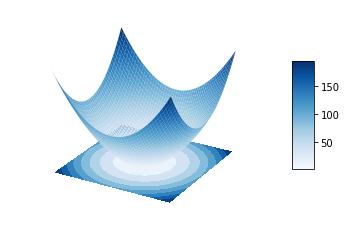

In [54]:
gd.plot()

#### **Descenso del gradiente con la otra función**

In [62]:
# function
def f(x: float, y: float) -> float:
    return np.sin(1/2 * x**2 - 1/4 * y**2 + 3) * np.cos(2*x + 1 - np.e**y)

# if we don't have an implementation of gradient, it uses its internal implementation
gd = GradientDescent(f, limx=5, limy=5, learning_rate=.2, delta=.0001)

gd.animation()
# necesario en colab
rc('animation', html='jshtml')
gd.anim

Una visualización en 3d de la otra función.

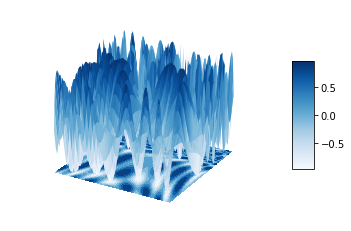

In [59]:
gd.plot()